In [1]:
from liblet import Production, Grammar, Derivation, ProductionGraph, closure, warn, show_calls, union_of, Stack, dod2table, dict2table

# Parsing deterministico

In [24]:
# fig. 8.1, pag. 236

G = Grammar.from_string("""
S -> a B | b A
A -> a | a S | b A A
B -> b | b S | a B B
""")

## SLL(1)

In [7]:
# fig. 8.4. pag. 238

G = Grammar.from_string("""
S -> a B
B -> b | a B b
""")
G

Grammar(N={B, S}, T={a, b}, P=(S -> a B, B -> b, B -> a B b), S=S)

In [8]:
def compute_table(G):
    TABLE = {A: dict() for A in G.N}

    for P in G.P:
        A, (a, *α) = P
        if a in TABLE[A]: 
            warn('Conflict on ({}, {}) for production {}'.format(A, a, P))
        else:
            TABLE[A][a] = P

    return TABLE

In [9]:
TABLE = compute_table(G)
dod2table(TABLE)

In [10]:
def predict(A, a): # dipende dalla variabile globale TABLE
    return TABLE[A][a] if a in TABLE[A] else None

## Parse (senza ε-regole)

In [11]:
def parse_noε(G, predict, INPUT):
    deriv = Derivation(G)
    rest = tuple(INPUT) + ('#', )
    stack = Stack(['#', G.S])
    while stack:
        top = stack.pop()
        if top in G.T | {'#'}:
            if rest[0] == top: 
                rest = rest[1:]
            else:
                warn('Expecting {}, got {}.'.format(top, rest[0]))
                return None
        else:
            pred = predict(top, rest[0])
            if pred is None:
                warn('No prediction for ({}, {}) at {}.'.format(top, rest[0], deriv) )
                return None 
            deriv = deriv.leftmost(G.P.index(pred))
            for X in pred.rhs[::-1]: stack.push(X)
    return deriv

In [13]:
parse_noε(G, predict, 'aabb')

S -> a B -> a a B b -> a a b b

### Un esempio: notazione prefissa

In [14]:
G = Grammar.from_string("""
E -> + E E | - E E | * E E | / E E | t
""")
G

Grammar(N={E}, T={*, +, -, /, t}, P=(E -> + E E, E -> - E E, E -> * E E, E -> / E E, E -> t), S=E)

In [15]:
TABLE = compute_table(G)
dod2table(TABLE)

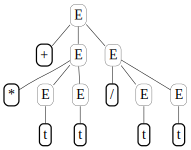

In [18]:
ProductionGraph(parse_noε(G, predict, '+ * t t / t t'.split()))

## LL(1) (senza ε-regole)

In [35]:
# fig. 8.7, pag. 240

G = Grammar.from_string("""
Session -> Fact Session | Question
Session -> ( Session ) Session
Fact -> ! STRING
Question -> ? STRING
""")
G

Grammar(N={Fact, Question, Session}, T={!, (, ), ?, STRING}, P=(Session -> Fact Session, Session -> Question, Session -> ( Session ) Session, Fact -> ! STRING, Question -> ? STRING), S=Session)

In [36]:
def compute_first(G):

    def recursive_first(X): # X è G.T | G.N
        return union_of(recursive_first(α[0]) for α in G.alternatives(X)) if X in G.N else {X}
    
    return {(X, ): recursive_first(X) for X in G.T | G.N}

In [37]:
FIRST = compute_first(G)
dict2table({N: ' '.join(FIRST[(N,)]) for N in G.N})

In [38]:
TABLE = {A: dict() for A in G.N} # c'è per forza A perché è produttivo, quindi FIRST(A) non sarà vuoto

for P in G.P:
    A, α = P
    for a in FIRST[(α[0], )]:        
        if a in TABLE[A]: 
            warn('Conflict on ({}, {}) for production {}'.format(A, a, P))
        else:
            TABLE[A][a] = P

dod2table(TABLE)

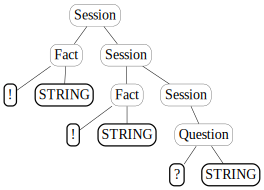

In [39]:
ProductionGraph(parse_noε(G, predict, '! STRING ! STRING ? STRING #'.split()))

# E le ε-regole? 

## (Full) LL(1)

In [40]:
# fig. 8.9, pag. 242

G = Grammar.from_string("""
Session -> Facts Question | ( Session ) Session
Facts -> Fact Facts | ε
Fact -> ! STRING
Question -> ? STRING
""")
G

Grammar(N={Fact, Facts, Question, Session}, T={!, (, ), ?, STRING}, P=(Session -> Facts Question, Session -> ( Session ) Session, Facts -> Fact Facts, Facts -> ε, Fact -> ! STRING, Question -> ? STRING), S=Session)

## Estendere FIRST

In [41]:
def tails(α):
    for i in range(len(α)): 
        yield α[i:]

def compute_first(G):

    FIRST = {}

    for N in G.N: 
        FIRST[(N, )] = set()
        for α in G.alternatives(N):
            for γ in tails(α):
                FIRST[γ] = set()
    for t in G.T: FIRST[(t, )] = {t}
    FIRST[tuple()] = {'ε'}
    FIRST[('ε', )] = {'ε'}
    FIRST[('#', )] = {'#'}

    @closure
    def comlpete_first(FIRST):
        for N, α in G.P:
            FIRST[(N, )] |= FIRST[α]
            for γ in tails(α):
                A, β = γ[0], γ[1:] # A in G.T | G.N
                FIRST[γ] |= FIRST[(A, )] - {'ε'}
                if 'ε' in FIRST[(A, )]: FIRST[γ] |= FIRST[β]
        return FIRST

    return comlpete_first(FIRST)

In [44]:
FIRST = compute_first(G)
dict2table({N: ' '.join(FIRST[(N, )]) for N in G.N})

## Prevedere dinamicamente

In [20]:
# versione iterativa

def dynamic_first(α): # dipende dalla variabile globale FIRST
    res = set()
    for X in α:
        if X in G.T | {'#'}: 
            res |= {X}
            return res
        else:
            fx = FIRST[(X, )]
            if 'ε' in fx:
                res |= fx - {'ε'}
            else:
                res |= fx
                return res
    return res | {'ε'}

In [45]:
@show_calls(True)
def dynamic_first(α): # dipende dalla variabile globale FIRST
    if not α: return {'ε'}
    X, γ = α[0], α[1:]
    fx = FIRST[(X, )]
    if 'ε' in fx:
        return (fx - {'ε'}) | dynamic_first(γ)
    else:
        return fx

In [47]:
dynamic_first(('Facts', 'Facts', 'Question', '#' ))

┌dynamic_first(('Facts', 'Facts', 'Question', '#'))
│┌dynamic_first(('Facts', 'Question', '#'))
││┌dynamic_first(('Question', '#'))
││└─ {'?'}
│└─ {'!', '?'}
└─ {'!', '?'}


{'!', '?'}

In [48]:
#@show_calls(True)
def dynamic_predict(A, a, stack): # dipende da dynamic_first che dipende dalla variabile globale TABLE
    prediction = None
    for α in G.alternatives(A):
        γ = α + tuple(stack)[::-1]
        if a in dynamic_first(γ):
            if prediction is None: 
                prediction = Production(A, α)
            else:
                warn('Conflict: γ = {}, a = {}, prediction was {}'.format(γ, a, prediction))
    return prediction

## Parse Full LL(1)

In [49]:
def parse_full(G, dynamic_predict, INPUT):
    deriv = Derivation(G)
    rest = tuple(INPUT) + ('#', )
    stack = Stack(['#', G.S])
    while stack:
        top = stack.pop()
        if top == 'ε': continue
        if top in G.T | {'#'}:
            if rest[0] == top: 
                rest = rest[1:]
            else:
                warn('Expecting {}, got {}.'.format(top, rest[0]))
                return None
        else:
            pred = dynamic_predict(top, rest[0], stack)
            if pred is None:
                warn('No prediction for ({}, {}) at {}.'.format(top, rest[0], deriv) )
                return None 
            deriv = deriv.leftmost(G.P.index(pred))
            for X in pred.rhs[::-1]: stack.push(X)
    return deriv

┌dynamic_first(('Facts', 'Question', '#'))
│┌dynamic_first(('Question', '#'))
│└─ {'?'}
└─ {'!', '?'}
┌dynamic_first(('(', 'Session', ')', 'Session', '#'))
└─ {'('}
┌dynamic_first(('Fact', 'Facts', 'Question', '#'))
└─ {'!'}
┌dynamic_first(('ε', 'Question', '#'))
│┌dynamic_first(('Question', '#'))
│└─ {'?'}
└─ {'?'}
┌dynamic_first(('!', 'STRING', 'Facts', 'Question', '#'))
└─ {'!'}
┌dynamic_first(('Fact', 'Facts', 'Question', '#'))
└─ {'!'}
┌dynamic_first(('ε', 'Question', '#'))
│┌dynamic_first(('Question', '#'))
│└─ {'?'}
└─ {'?'}
┌dynamic_first(('!', 'STRING', 'Facts', 'Question', '#'))
└─ {'!'}
┌dynamic_first(('Fact', 'Facts', 'Question', '#'))
└─ {'!'}
┌dynamic_first(('ε', 'Question', '#'))
│┌dynamic_first(('Question', '#'))
│└─ {'?'}
└─ {'?'}
┌dynamic_first(('?', 'STRING', '#'))
└─ {'?'}


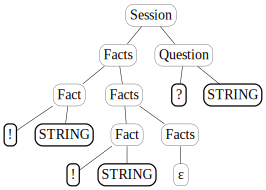

In [51]:
ProductionGraph(parse_full(G, dynamic_predict, '! STRING ! STRING ? STRING #'.split()))

### Un esempio maggiormente realistico

In [52]:
# MCD, fig. 3.4, pag. 123

G = Grammar.from_string("""
input -> expression
expression -> term rest_expression
term -> IDENTIFIER | parenthesized_expression 
parenthesized_expression -> ( expression ) 
rest_expression -> + expression | ε
""")
G

Grammar(N={expression, input, parenthesized_expression, rest_expression, term}, T={(, ), +, IDENTIFIER}, P=(input -> expression, expression -> term rest_expression, term -> IDENTIFIER, term -> parenthesized_expression, parenthesized_expression -> ( expression ), rest_expression -> + expression, rest_expression -> ε), S=input)

In [54]:
FIRST = compute_first(G)
dict2table({N: ' '.join(FIRST[(N, )]) for N in G.N})

┌dynamic_first(('expression', '#'))
└─ {'IDENTIFIER', '('}
┌dynamic_first(('term', 'rest_expression', '#'))
└─ {'IDENTIFIER', '('}
┌dynamic_first(('IDENTIFIER', 'rest_expression', '#'))
└─ {'IDENTIFIER'}
┌dynamic_first(('parenthesized_expression', 'rest_expression', '#'))
└─ {'('}
┌dynamic_first(('+', 'expression', '#'))
└─ {'+'}
┌dynamic_first(('ε', '#'))
│┌dynamic_first(('#',))
│└─ {'#'}
└─ {'#'}
┌dynamic_first(('term', 'rest_expression', '#'))
└─ {'IDENTIFIER', '('}
┌dynamic_first(('IDENTIFIER', 'rest_expression', '#'))
└─ {'IDENTIFIER'}
┌dynamic_first(('parenthesized_expression', 'rest_expression', '#'))
└─ {'('}
┌dynamic_first(('(', 'expression', ')', 'rest_expression', '#'))
└─ {'('}
┌dynamic_first(('term', 'rest_expression', ')', 'rest_expression', '#'))
└─ {'IDENTIFIER', '('}
┌dynamic_first(('IDENTIFIER', 'rest_expression', ')', 'rest_expression', '#'))
└─ {'IDENTIFIER'}
┌dynamic_first(('parenthesized_expression', 'rest_expression', ')', 'rest_expression', '#'))
└─ {'('}
┌dynam

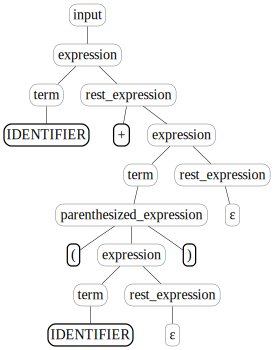

In [57]:
ProductionGraph(parse_full(G, dynamic_predict, 'IDENTIFIER + ( IDENTIFIER )'.split()))